In [1]:
from dask import delayed, visualize
import dask_geopandas as dask_gpd
import functions as f
import geopandas as gpd

In [27]:
BUFFER = 40
SAMPLE = 2_000_000
# SAMPLE = 50_0000

In [18]:
bikelane_wgs84 = gpd.read_parquet('dataset/raw_unprocessed/bikelane_dk_WGS84_h3_indexed.parquet')
bikelane_wgs84_demo = bikelane_wgs84.sample(SAMPLE)
bikelane_wgs84_demo.sort_values('h3_index', inplace=True)

In [19]:
# drop multi index
PARTITIONS = 16
bikelane_wgs84_demo = bikelane_wgs84_demo.reset_index(drop=True)
bikelane_dk_demo = bikelane_wgs84_demo.to_crs(f.DENMARK_CRS)
d_gdf = dask_gpd.from_geopandas(bikelane_dk_demo, npartitions=PARTITIONS)

In [20]:
import geopandas as gpd
import pandas as pd
from dask import delayed
import dask_geopandas as dgpd
from dask.distributed import Client

In [28]:

d_gdf = dgpd.from_geopandas(bikelane_dk_demo, npartitions=PARTITIONS)

@delayed
def BasicTask(gdf):

    gdf = gdf.buffer(BUFFER)

    gdf = f.geoseries_to_geopandas(gdf, crs=f.DENMARK_CRS)
    gdf = f.multipolygon_to_gdf(gdf.unary_union, crs=f.DENMARK_CRS)

    #gdf = DENMARK.intersection(gdf)

    #gdf = f.geoseries_to_geopandas(gdf, crs=f.DENMARK_CRS)
    #done.to_parquet(f'dataset/processed/bikelane_{t}_minutes_dk.parquet')
    return gdf

@delayed
def UnaryUnion(gdf1, gdf2):
    # Assuming gdf1 and gdf2 are your GeoDataFrames
    combined_gdf = gpd.GeoDataFrame(pd.concat([gdf1.geometry, gdf2.geometry], ignore_index=True))

    # Now compute the unary union
    #unary_union_result = combined_gdf.explode().unary_union
    unary_union_result = combined_gdf.unary_union
    gdf = f.multipolygon_to_gdf(unary_union_result, crs=f.DENMARK_CRS)

    return gdf

# Load and process partitions
load = [BasicTask(d_gdf.get_partition(i)) for i in range(PARTITIONS)]

# Recursive function to reduce partitions by applying UnaryUnion
def reduce_partitions(partitions):
    if len(partitions) <= 1:
        return partitions
    reduced = []
    for i in range(0, len(partitions), 2):
        if i + 1 < len(partitions):
            reduced.append(UnaryUnion(partitions[i], partitions[i+1]))
        else:
            reduced.append(partitions[i])
    return reduce_partitions(reduced)

final_result = reduce_partitions(load)

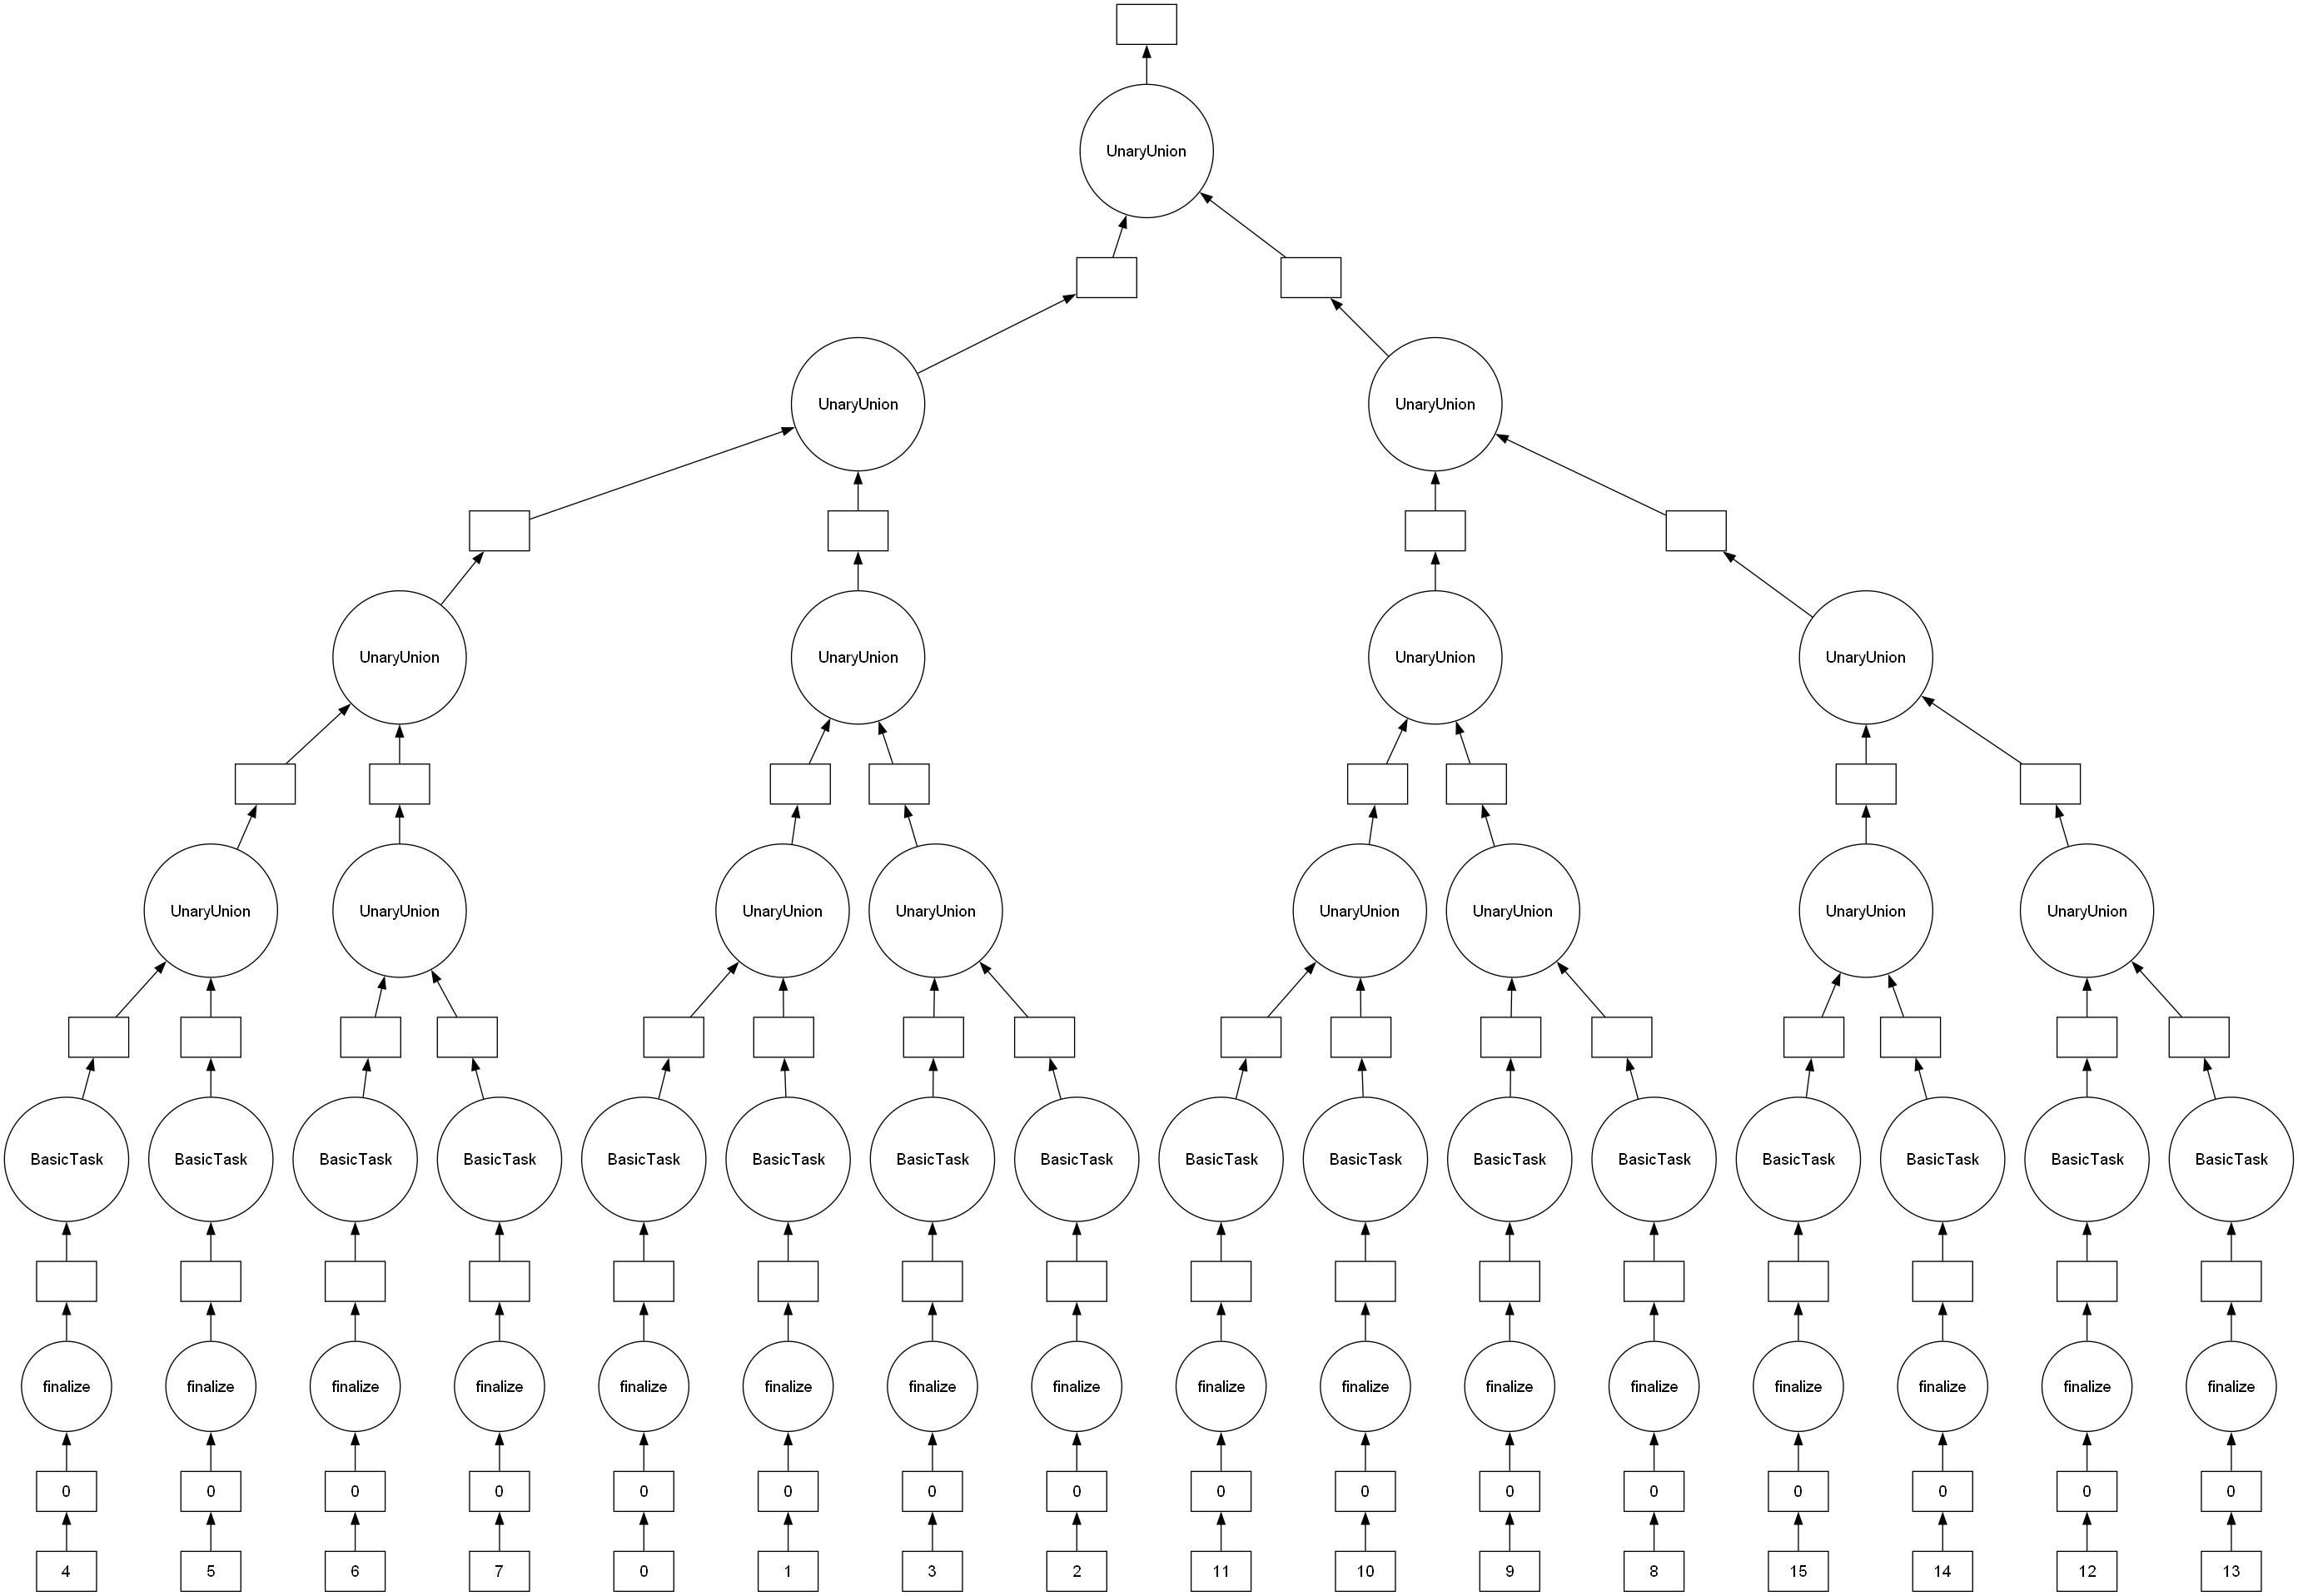

In [26]:
visualize(final_result)

In [16]:
# Set up a Dask client and compute the result
client = Client()  # Make sure your Dask cluster is appropriately configured
result = client.compute(final_result[0])
final_result_df = result.result()
#del result
#print(final_result_df)
final_result_df.to_parquet(f'dataset/processed/bikelane_test_40.parquet')
#del

C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64723 instead
  warnings.warn(
C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 46.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


0
2
4
6
0
2
0


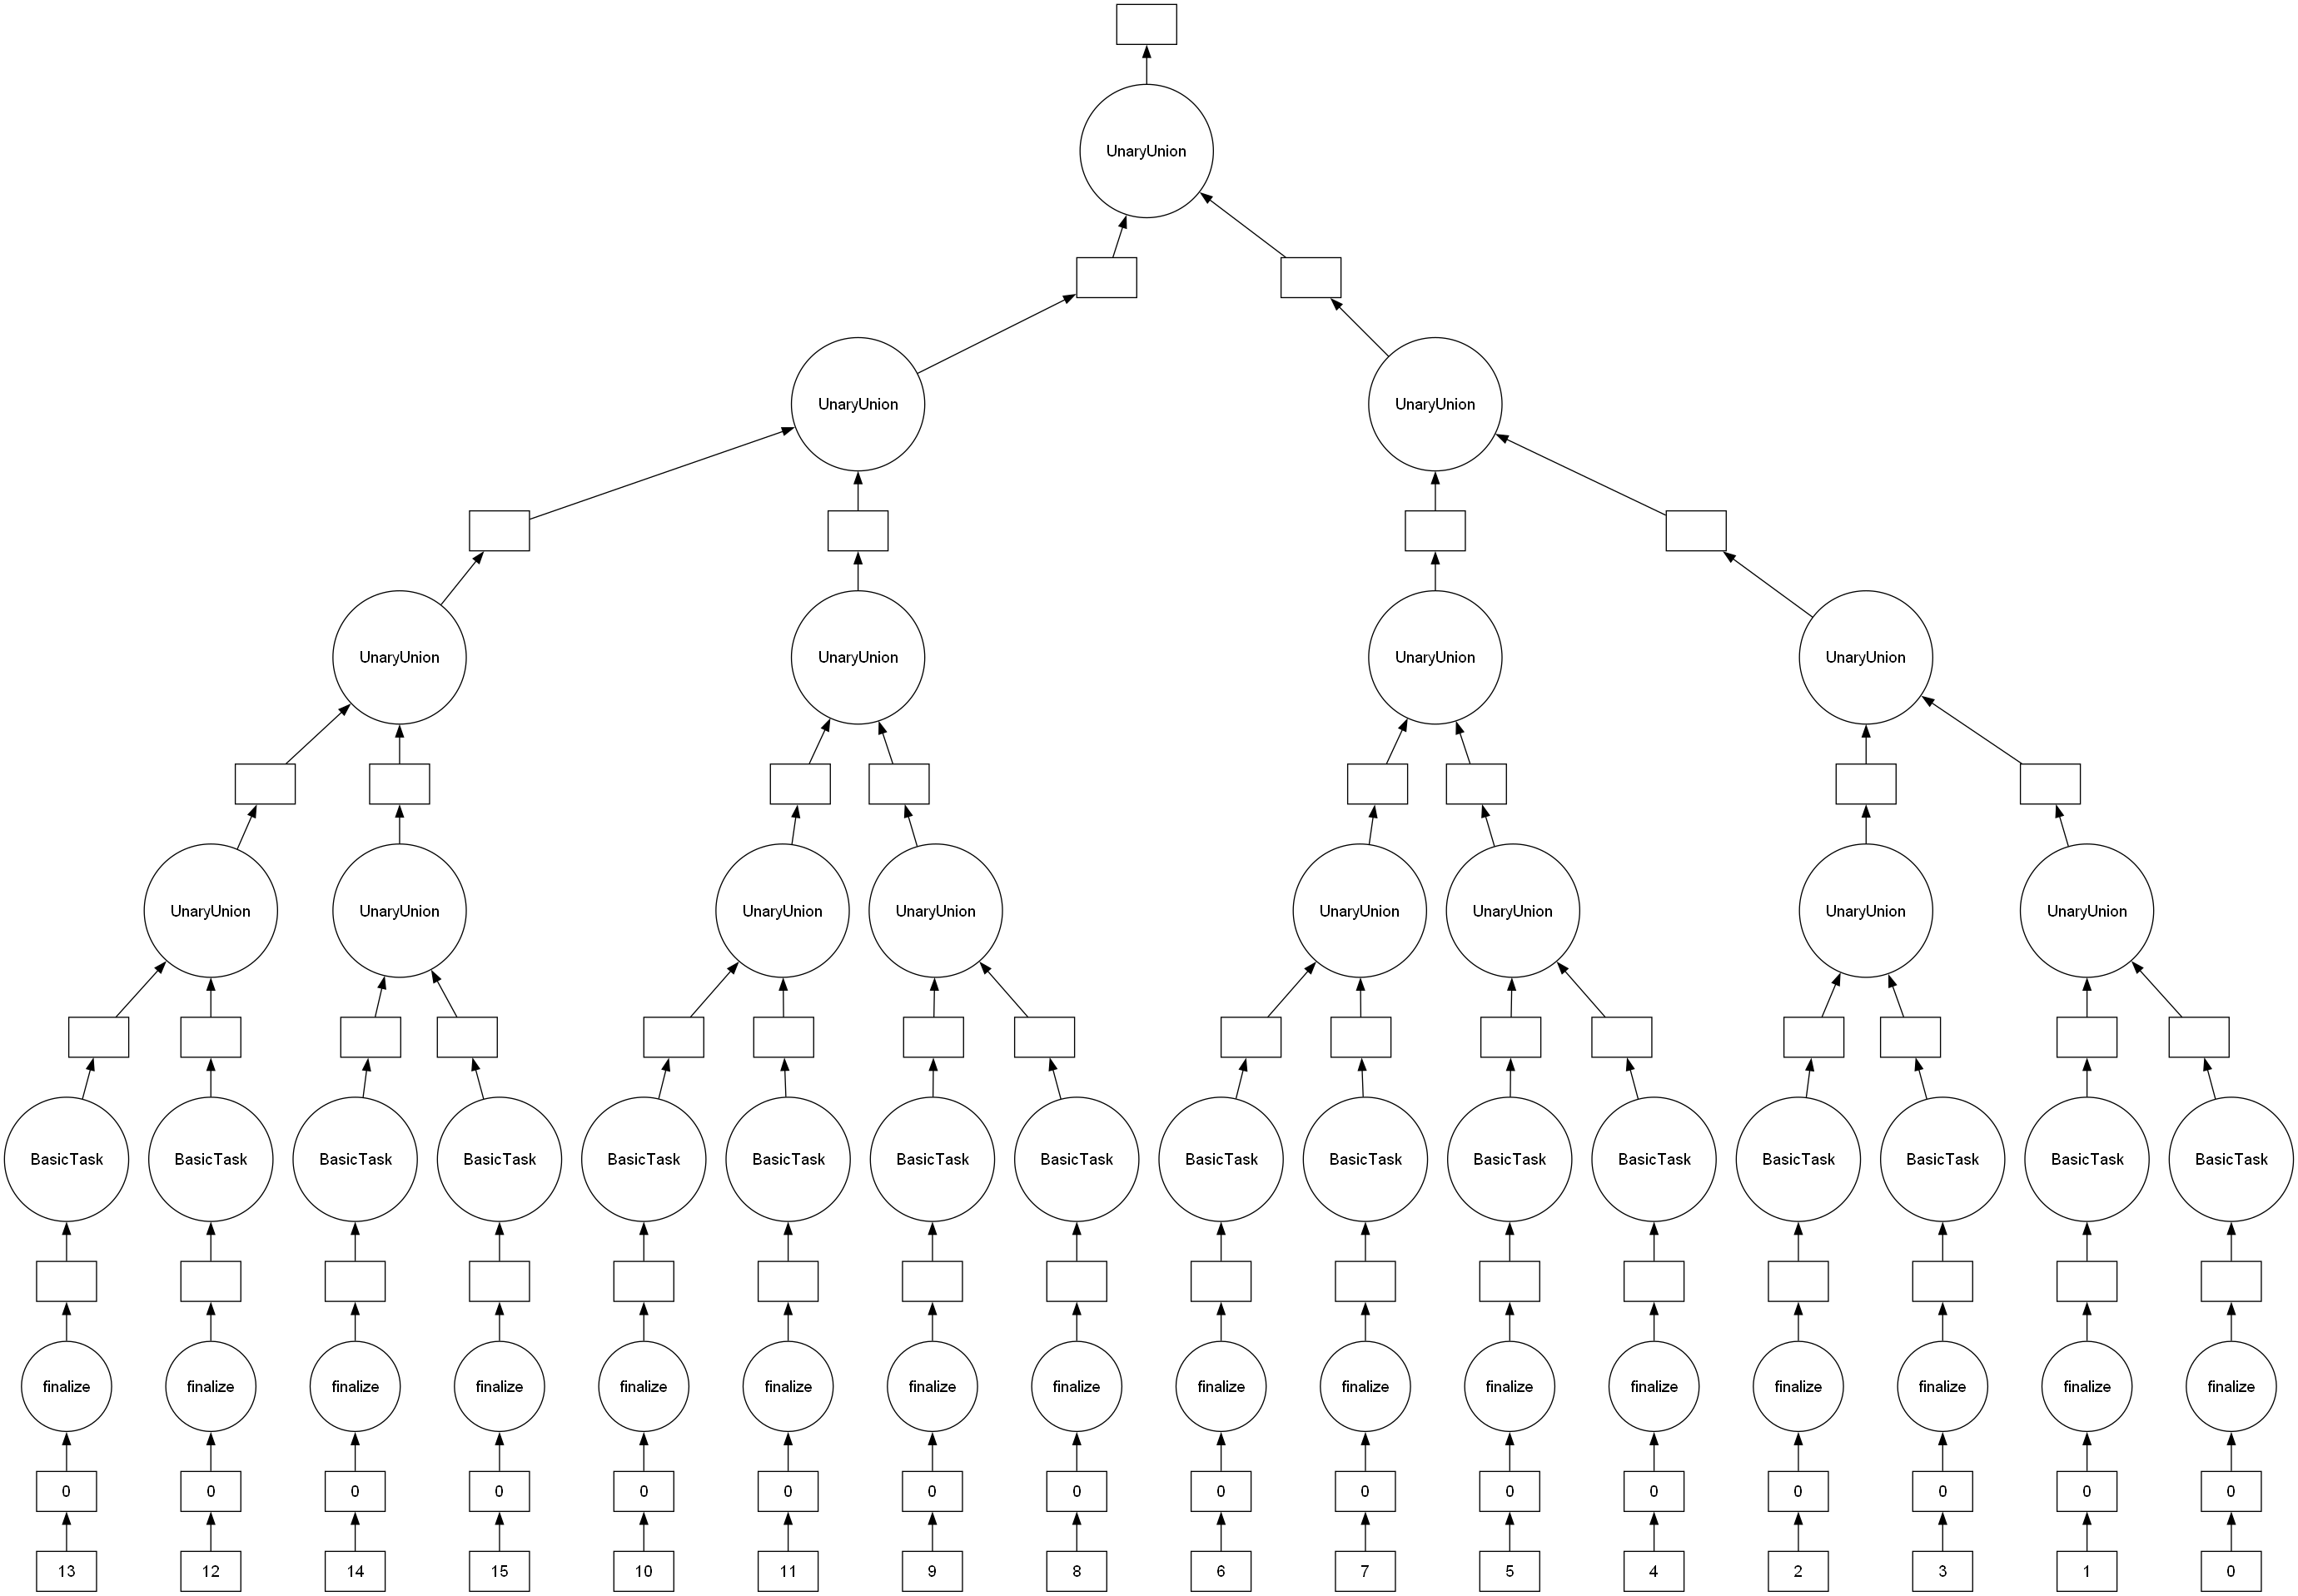

In [24]:

# Building the task graph
load = []
for i in range(PARTITIONS):
    load.append(BasicTask(d_gdf.get_partition(i)))

parents_1 = []
for i in range(0, PARTITIONS, 2):
    parents_1.append(UnaryUnion(load[i], load[i+1]))

parents_2 = []
for i in range(0, len(parents_1), 2):
    print(i)
    parents_2.append(UnaryUnion(parents_1[i], parents_1[i+1]))

parents_3 = []
for i in range(0, len(parents_2), 2):
    print(i)
    parents_3.append(UnaryUnion(parents_2[i], parents_2[i+1]))

parents_4 = []
for i in range(0, len(parents_3), 2):
    print(i)
    parents_4.append(UnaryUnion(parents_3[i], parents_3[i+1]))

results_1 = [p for p in parents_1]
results_2 = [p for p in parents_2]
results_3 = [p for p in parents_3]
results_4 = [p for p in parents_4]
#store_result = store(analyze_result)

# Visualize the task graph
visualize([results_4], filename='task_graph.png')  # This saves the graph

In [32]:
from dask.distributed import Client

client = Client()  # Set up a Dask client to manage execution
result = client.compute(results_4)  # This triggers the execution of the entire task graph
#result = result.result()  # To get the actual result after computation

C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60845 instead
  warnings.warn(
C:\Users\Gergo Gyori\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3161: UserWarning: Sending large graph of size 185.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [34]:
from dask.threaded import get

In [36]:
result = get(result)

TypeError: get() missing 1 required positional argument: 'keys'

In [41]:
def store(result):
    None

In [42]:
get(results_4, keys='result')

TypeError: cannot convert dictionary update sequence element #0 to a sequence